## Qiu Yue 作业

预测图像的**左右对称性**

我们提供了一个模板代码，包括

- 数据读取
- 数据预览（观察数据集）
- 数据预处理：图片翻转，格式转换
- 训练框架：tensorflow的batch读取，loss计算，反向传播和准确率评估等模块

只需在BasicCNN模块的network函数中注释部分填入网络结构即可进行训练、模型评估等步骤

### 安装opencv, tensorflow

pip install opencv-python
pip install tensorflow

In [1]:
import os
import re
import cv2
import numpy as np
import math
import random

train_fpath="data/blob_train_image_data/"
test_fpath="data/blob_test_image_data/"

### 数据读取

In [2]:
# 读取训练数据
num_train_samples = 16000
x_train = np.zeros((num_train_samples, 32 * 32), dtype='uint8')
y_train = np.zeros((num_train_samples,), dtype='uint8')
train_file_object = open(os.path.join(train_fpath, "index_sym.txt"))

for i, filename_y in enumerate(train_file_object.readlines()):
    filename, y = filename_y.rstrip('\n').split(' ')
    img = cv2.imread(os.path.join(train_fpath, filename), cv2.IMREAD_GRAYSCALE)
    x_train[i] = img.reshape(32 * 32,)
    y_train[i] = y

# 读取测试数据
num_test_samples = 3200
x_test = np.zeros((num_test_samples, 32 * 32), dtype='uint8')
y_test = np.zeros((num_test_samples, ), dtype='uint8')
test_file_object = open(os.path.join(test_fpath, "index_sym.txt"))

for i, filename_y in enumerate(test_file_object.readlines()):
    filename, y = filename_y.rstrip('\n').split(' ')
    img = cv2.imread(os.path.join(test_fpath, filename), cv2.IMREAD_GRAYSCALE)
    x_test[i] = img.reshape(32 * 32,)
    y_test[i] = y
    

In [3]:
y_test.shape

(3200,)

### 数据预览

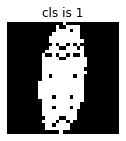

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2, 10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((32, 32))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

index = random.randint(0, len(x_train))
show_digit(x_train[index], 'cls is {}'.format(y_train[index]))


### 将输出改为one hot形式（便于使用cross entropy loss）

In [5]:
def make_one_hot(data):
    return (np.arange(2) == data[:, None]).astype(np.integer)

y_train = make_one_hot(y_train)
y_test = make_one_hot(y_test)

print(x_test.shape, y_test.shape)
print(x_train.shape, y_train.shape)


(3200, 1024) (3200, 2)
(16000, 1024) (16000, 2)


### 数据集shuffle

In [6]:
random.seed(49)
train_idx = list(range(y_train.shape[0]))
random.shuffle(train_idx)
x_train = x_train[train_idx[:5000], ]
y_train = y_train[train_idx[:5000], ]
test_idx = list(range(y_test.shape[0]))
random.shuffle(test_idx)
x_test = x_test[test_idx[:500], ]
y_test = y_test[test_idx[:500], ]

print(y_train.shape, x_train.shape)
print(y_test.shape, x_test.shape)

(5000, 2) (5000, 1024)
(500, 2) (500, 1024)


In [7]:
x_train = x_train.reshape(5000, 32*32)
x_test = x_test.reshape(500, 32*32)

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
import tensorflow as tf
import keras
import numpy as np
import re
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam

Using TensorFlow backend.


Train on 5000 samples, validate on 500 samples
Epoch 1/66
5000/5000 [==============================] - 2s 431us/step - loss: 0.8060 - acc: 0.4874 - val_loss: 0.6927 - val_acc: 0.5240
Epoch 2/66
5000/5000 [==============================] - 1s 274us/step - loss: 0.7468 - acc: 0.4998 - val_loss: 0.6921 - val_acc: 0.5240
Epoch 3/66
5000/5000 [==============================] - 1s 250us/step - loss: 0.7377 - acc: 0.4936 - val_loss: 0.6939 - val_acc: 0.4760
Epoch 4/66
5000/5000 [==============================] - 1s 299us/step - loss: 0.7251 - acc: 0.4944 - val_loss: 0.6935 - val_acc: 0.4760
Epoch 5/66
5000/5000 [==============================] - 1s 263us/step - loss: 0.7153 - acc: 0.4990 - val_loss: 0.6936 - val_acc: 0.4760
Epoch 6/66
5000/5000 [==============================] - 1s 269us/step - loss: 0.7113 - acc: 0.4940 - val_loss: 0.6939 - val_acc: 0.4760
Epoch 7/66
5000/5000 [==============================] - 1s 297us/step - loss: 0.7076 - acc: 0.5038 - val_loss: 0.6897 - val_acc: 0.5240
E

Text(0, 0.5, 'Acc')

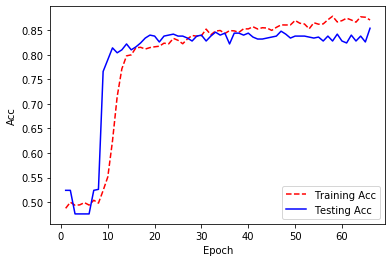

In [11]:
# 重点是 optimizer 的选择，多做尝试

model = Sequential()
model.add(Dense(input_dim=32*32, units=666, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(units=666, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(units=42, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(units=49, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(units=49, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=100, epochs=66, validation_data=(x_test, y_test))

# 对比train和test的accuracy
training_acc = history.history['acc']
test_acc = history.history['val_acc']

epoch_count = range(1, len(training_acc) + 1)

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Acc', 'Testing Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')